In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from scipy.signal import stft, istft
from scipy.fftpack import fft, fftshift, fftfreq
from IPython.display import Audio
from tqdm import tnrange, tqdm_notebook
from dlbeamformer_utilities import compute_steering_vectors_single_frequency,\
    compute_steering_vectors, simulate_multichannel_tf, compute_sinr,\
    compute_mvdr_tf_beamformers, check_distortless_constraint,\
    compute_tf_beampattern, visualize_beampattern_2d, \
    visualize_beampattern_1d, visualize_beampattern_1d_average,\
    simulate_multichannel_tf_circular, simulate_multichannel_tf_mixtures,\
    compute_tf_beamformer_output
from utilities import load_data, parse_parameters, config_figures,\
    to_db, visualize_tf
from IPython.display import Audio

random_seed = 0
# Make pretty figures
palette, cmap = config_figures()

VISUALIZE_BEAMPATTERNS = False

In [2]:
datapath = "CMU_ARCTIC/cmu_us_bdl_arctic/wav"
train_data, test_data = load_data(datapath)

sampling_frequency, stft_params, sound_speed = parse_parameters()
signal_max_frequency = sampling_frequency / 2

# Array geometry
pos_x = np.array([-35.0, -35.0, 0.0, 35.0, 35.0, 0.0, 0.0]) * 1e-3
pos_y = np.array([20.0, -20.0, -40.0, -20.0, 20.0, 40.0, 0.0]) * 1e-3
n_mics = len(pos_x)
pos_z = np.zeros(n_mics)
array_geometry = np.row_stack((pos_x, pos_y, pos_z))

# Fix elevation angle
elevation = -90 # [degree]

# Source/Target/Look angles
elevation_s = np.array([elevation]) # [degree]
azimuth_s = np.array([180])
source_steering_vectors = compute_steering_vectors(array_geometry, 
        sampling_frequency=sampling_frequency, n_fft_bins=stft_params["n_fft_bins"], 
        elevation_grid=elevation_s, 
        azimuth_grid=azimuth_s)

# Scanning angles
scanning_elevation_grid = np.array([elevation]) # [degree]
scanning_azimuth_grid = np.arange(0, 360, 0.1) # [degree]
scanning_steering_vectors = compute_steering_vectors(array_geometry, 
        sampling_frequency=sampling_frequency, n_fft_bins=stft_params["n_fft_bins"], 
        elevation_grid=scanning_elevation_grid, 
        azimuth_grid=scanning_azimuth_grid)

In [3]:
ds_tf_beamformers = 1./n_mics * source_steering_vectors

# Delay-sum beam pattern
ds_tf_beampattern = compute_tf_beampattern(ds_tf_beamformers, scanning_steering_vectors)
ds_tf_beampattern_db = to_db(ds_tf_beampattern)

if VISUALIZE_BEAMPATTERNS:
    frequency_bins = [7, 31, 63, 127]
    visualize_beampattern_1d(ds_tf_beampattern_db[:, 0, :], scanning_azimuth_grid, frequency_bins, 
        signal_max_frequency, source_azimuths= azimuth_s, title="Delay-sum TF beam patterns")

    visualize_beampattern_1d_average(np.abs(ds_tf_beampattern[:, 0, :]), scanning_azimuth_grid, 
        frequency_range=(0, 63), source_azimuths=azimuth_s, title="Delay-sum TF average beam pattern")

    visualize_beampattern_2d(np.abs(ds_tf_beampattern[:, 0, :]), 
        scanning_azimuth_grid, signal_max_frequency);

DS Output SINR: 0.62 dB


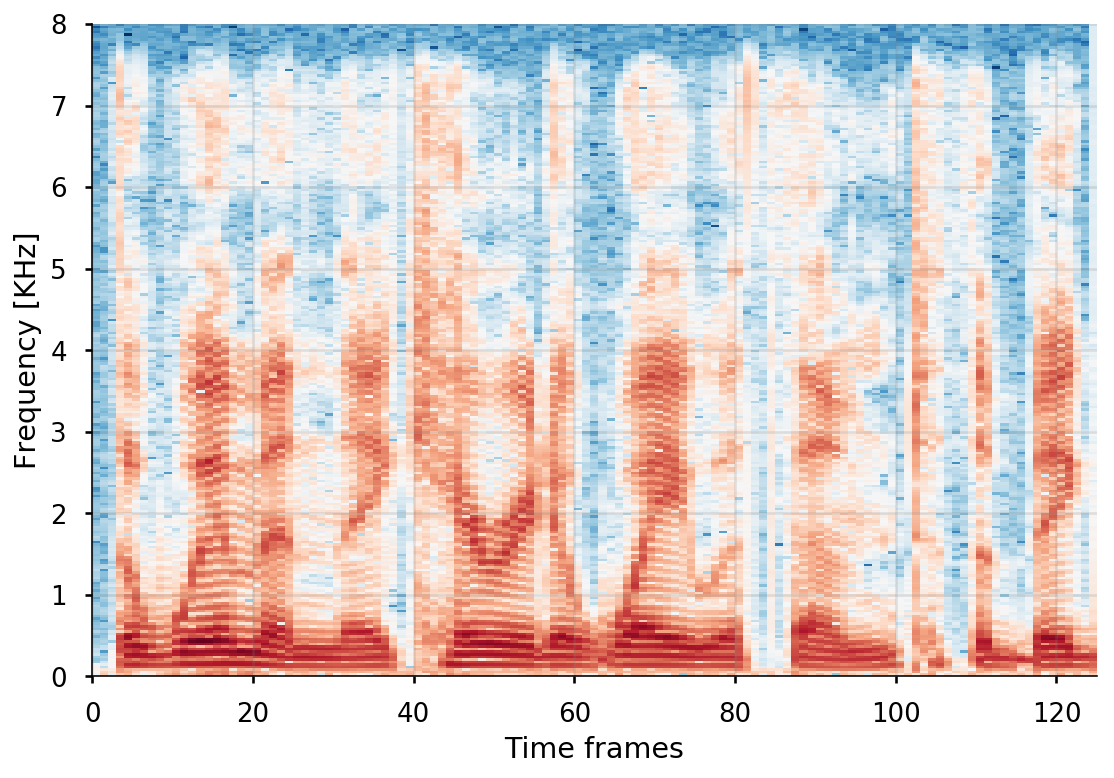

In [15]:
# Test signal
i_test = np.random.choice(len(test_data))
source = {
    "signal": test_data[i_test],
    "elevation": elevation_s,
    "azimuth": azimuth_s
}
interferences = []
interference = {
    "signal": test_data[i_test],
    "elevation": np.array([elevation]),
    "azimuth": np.array([87])
}
interferences.append(interference)

received_stft_multichannel, source_stft_multichannel, interference_stft_multichannel \
    = simulate_multichannel_tf_mixtures(array_geometry, source,
        interferences, sampling_frequency, stft_params)

ds_out, ds_tf_out, _ = compute_tf_beamformer_output(ds_tf_beamformers[:, 0, 0, :], received_stft_multichannel, 
                            sampling_frequency, stft_params)
visualize_tf(source_stft_multichannel[:, 0, :], sampling_frequency, cmap=cmap)
ds_out_sinr = compute_sinr(source_stft_multichannel, interference_stft_multichannel, ds_tf_beamformers[:, 0, 0, :])
print("DS Output SINR: {:.2f} dB".format(ds_out_sinr[0][0]))
Audio(source["signal"], rate=sampling_frequency, autoplay=True)

In [11]:
interference_stft_multichannel.shape

(256, 7, 125)